<a href="https://colab.research.google.com/github/derevoAM/Phys_labs/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6
## Tracking a High-Speed Train under Biased Process Dynamics
---
Course - Experimental Data Processing

**Team 7 :** Dmitij Kosenkov, Mikhail Derevianchenko, Daniia Zinniatullina  
**Date :**  October 13, 2025

# Project description
This project is dedicated to understanding the behaviour of Kalman Filter in cases of accounting for systematic biases and not accounting, comparing contributions of random estimations error and systematic error into total error.

# Step 1. Filtering the data

Our first step is to process measurements, provided by GPS.

In [167]:
import numpy as np
import matplotlib.pyplot as plt

In [168]:
measurements = np.loadtxt('GPS.txt', usecols=0)
dt = 2
time  = np.arange(0, measurements.size * dt, dt)

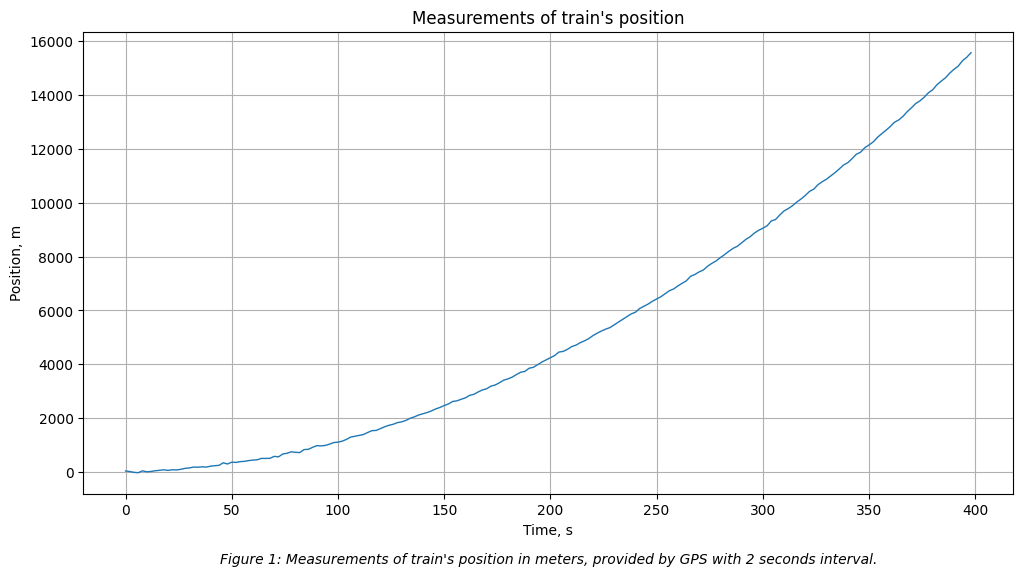

In [169]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, measurements, linewidth=1, alpha=1)
ax.set_xlabel('Time, s')
ax.set_ylabel('Position, m')
ax.set_title("Measurements of train's position")
ax.grid(True)

ax.text(0.5, -0.15, "Figure 1: Measurements of train's position in meters, provided by GPS with 2 seconds interval.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

Now we need to filter the data. In order to do that, lets construct a Kalman Filter class, which will be responsible for filtering data. Main functions of this class: predict(each step), filtrate(each step), filter_all(filtering for all steps), restart(reinitialization of Kalman Filter), calc_residuals, calc_biased_error, calc_tru_error. Last 3 functions will be used in future steps.

In [170]:
class KalmanFilter:

  def __init__(self, F, G, H, Q, R, P, X, measurements, sigma_acc):
    self.F = F
    self.G = G
    self.H = H
    self.Q = Q
    self.R = R
    self.P = P
    self.X_0 = X
    self.P_predict_arr = np.zeros((measurements.size, 2, 2))
    self.P_predict_arr[0] = P
    self.P_filter_arr = np.zeros((measurements.size, 2, 2))
    self.P_filter_arr[0] = P
    self.P_filter = P
    self.P_predict = P
    self.X_predict = X
    self.X_filter = X
    self.S = np.zeros(measurements.size)
    self.measurements = measurements
    self.filtered = np.zeros((measurements.size, 2))
    self.predicted = np.zeros((measurements.size, 2))
    self.sigma_acc = sigma_acc
    self.filtered[0] = X
    self.predicted[0] = X
    self.q = 0
    self.mu = np.zeros((measurements.size, 2))
    self.mu_predict = np.zeros((measurements.size, 2))


  def predict(self, i):
    self.X_predict = self.F @ self.X_filter + np.array([self.G[0][0], self.G[1][0]]) * self.q
    self.P_predict = np.dot(np.dot(F, self.P_filter), F.T) + self.Q


  def filtrate(self,i):
    self.S[i] = (self.H @ self.P_predict @ self.H.T + R)[0][0]
    self.K =  self.P_predict @ H.T @ np.linalg.inv(H @ self.P_predict @ H.T + R)
    self.P_filter = (np.identity(self.P.shape[0]) - self.K @ self.H) @  self.P_predict @ (np.identity(self.P.shape[0]) - self.K @ self.H).transpose() + self.K * self.R @ self.K.T
    self.P_filter_arr[i] = self.P_filter
    self.P_predict_arr[i] = self.P_predict
    self.X_filter = self.X_predict + self.K @ (self.measurements[i] - self.H @ self.X_predict)
    self.filtered[i] = self.X_filter
    self.predicted[i] = self.X_predict

  def filter_all(self):
    self.restart()
    for i in range(0, self.measurements.size):
      self.predict(i)
      self.filtrate(i)
    return self.filtered

  def restart(self):
    self.P_predict_arr = np.zeros((measurements.size, 2, 2))
    self.P_predict_arr[0] = self.P
    self.P_filter_arr = np.zeros((measurements.size, 2, 2))
    self.P_filter_arr[0] = self.P
    self.P_filter = self.P
    self.P_predict = self.P
    self.X_predict = self.X_0
    self.X_filter = self.X_0
    self.S = np.zeros(measurements.size)
    self.measurements = measurements
    self.filtered = np.zeros((measurements.size, 2))
    self.predicted = np.zeros((measurements.size, 2))
    self.sigma_acc = sigma_acc
    self.filtered[0] = self.X_0
    self.predicted[0] = self.X_0
    self.mu = np.zeros((measurements.size, 2))
    self.mu_predict = np.zeros((measurements.size, 2))

  def calc_residuals(self):
    self.residuals = np.zeros(self.measurements.size)
    for i in range(1, self.measurements.size):
      self.residuals[i] = self.measurements[i] - (self.H @ self.predicted[i])[0]
    return self.residuals

  def calc_biased_error(self):
    for i in range(1, self.measurements.size):
      self.mu_predict[i] = self.F @ self.mu[i - 1] + np.array([self.G[0][0], self.G[1][0]]) * self.q
      self.mu[i]  = (np.identity((self.K @ H).shape[0]) - self.K @ H) @ self.mu_predict[i]

  def calc_true_error(self):
    self.true_x = np.sqrt(self.P_filter_arr[:, 0, 0] + self.mu[:, 0]**2)
    self.true_v = np.sqrt(self.P_filter_arr[:, 1, 1] + self.mu[:, 1]**2)
    return self.true_x, self.true_v

sigma_acc = 0.2
sigma_measur = 20


x_0 = np.array([2, 0])
P_0 = np.array([[100, 0], [0, 100]])
F = np.array([[1, dt], [0, 1]])
G = np.array([[(dt ** 2) / 2], [dt]])
H = np.array([[1, 0]])
R = np.array([sigma_measur**2])
Q = G @ G.transpose() * sigma_acc**2
filter = KalmanFilter(F, G, H, Q, R, P_0, x_0, measurements.copy(), sigma_acc)
filtered_measur = filter.filter_all()


Lets plot measurements and filtered data together and compare it.

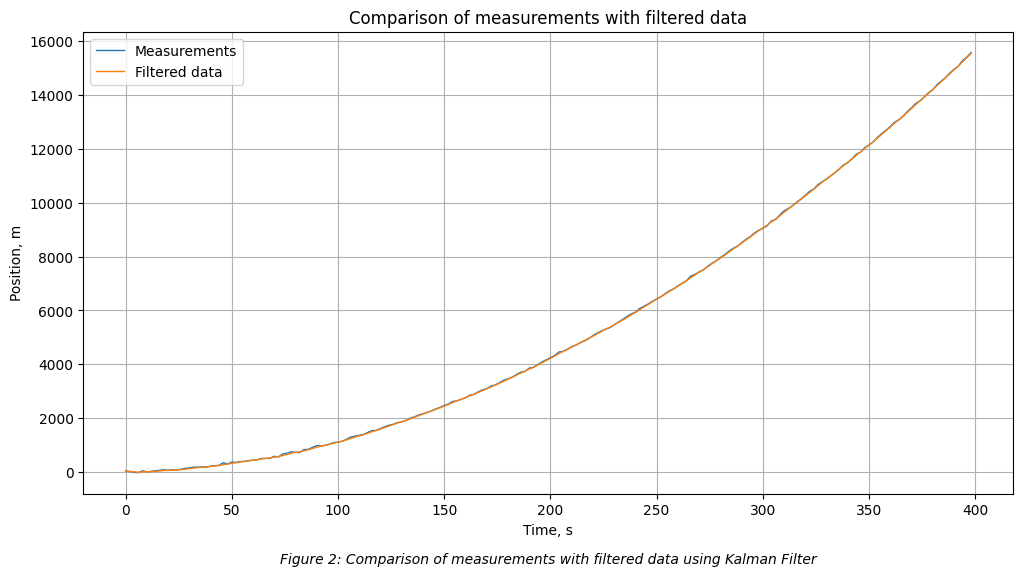

In [171]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, measurements, linewidth=1, alpha=1, label='Measurements')
ax.plot(time, filtered_measur[:, 0], linewidth=1, alpha=1, label='Filtered data')
ax.set_xlabel('Time, s')
ax.set_ylabel('Position, m')
ax.set_title('Comparison of measurements with filtered data')
ax.grid(True)

ax.legend()
ax.text(0.5, -0.15, "Figure 2: Comparison of measurements with filtered data using Kalman Filter",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

From Figure 2 we can't directly see whether filter appear overconfident or systematically shifted. For that reason lets plot difference between measurements and filtered data.

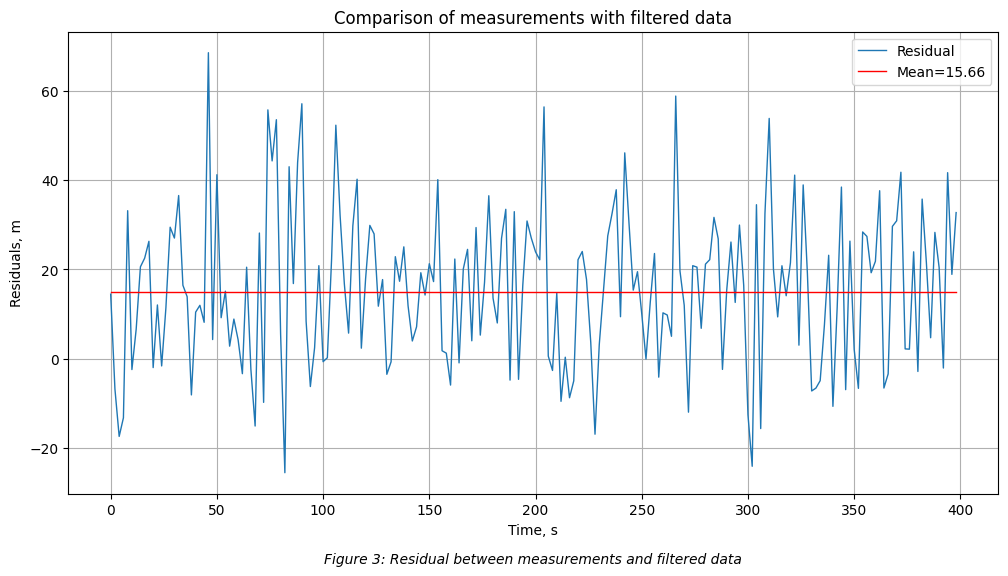

In [172]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, measurements - filtered_measur[:, 0], linewidth=1, alpha=1, label='Residual')
mean = (measurements - filtered_measur[:, 0]).mean()
ax.plot(time, np.full_like(time, mean), linewidth=1, alpha=1, color='r', label=f'Mean={mean:.2f}')
ax.set_xlabel('Time, s')
ax.set_ylabel('Residuals, m')
ax.set_title('Comparison of measurements with filtered data')
ax.grid(True)

ax.legend()
ax.text(0.5, -0.15, "Figure 3: Residual between measurements and filtered data",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

As you can see from Figure 3, the mean of calculated residual is shifted by 11.04 above 0, which means that filter appears to be systematically shifted. IT IS DIFFERENT RESIDUAL PLOT FROM ONE IN STEP 2.

Also the following plot shows filter estimate for velocity.

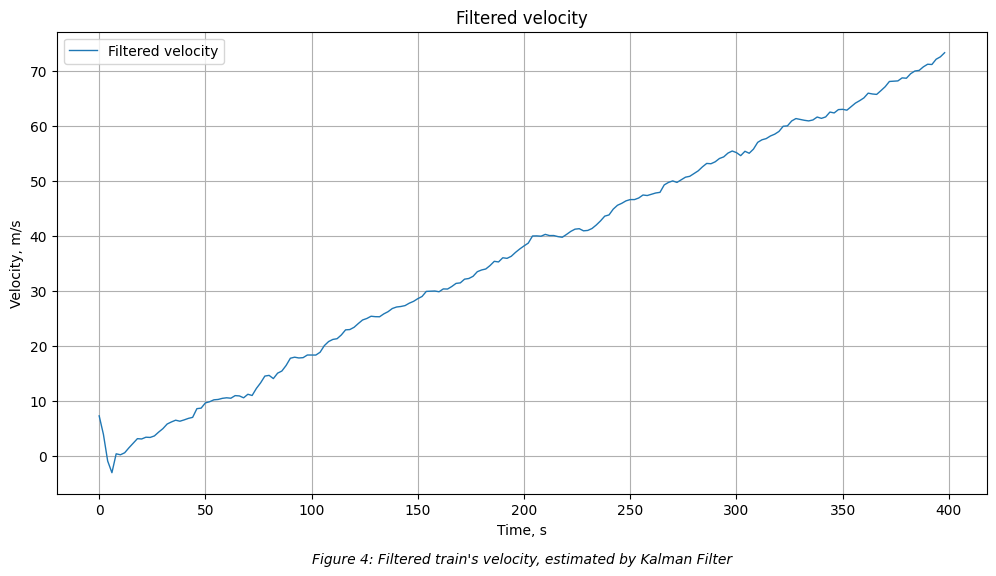

In [173]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, filtered_measur[:, 1], linewidth=1, alpha=1, label='Filtered velocity')
ax.set_xlabel('Time, s')
ax.set_ylabel('Velocity, m/s')
ax.set_title('Filtered velocity')
ax.grid(True)

ax.legend()
ax.text(0.5, -0.15, "Figure 4: Filtered train's velocity, estimated by Kalman Filter",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

# Step 2. Checking residuals for signs of bias

As we saw from Figure 3, filter was systematically shifted. In order to check whether the model is biased, we will perform statistical checks based on the filter residuals.

Filter residual represent the mismatch between the measurement at time i and the corresponding prediction for that time step: $r_{i} = z_{i} - HX_{i,i-1}$

The variance $S_{i}$ represents how much
uncertainty the filter expects in the residual at step i: $S_{i} = HP_{i,i-1}H^{T}+R$. $\sqrt{S_{i}}$ (standard deviation of the residuals) shows the typical range within which the residuals are expected to fluctuate,
if the filter model is consistent.

For an optimal Kalman Filter, filter residuals should have zero mean and be uncorrelated over time, in other words, behave like white noise. To check that, we calculate residuals and variance and then plot them together to see whether model is biased.

Mean residual: 20.627224977404968


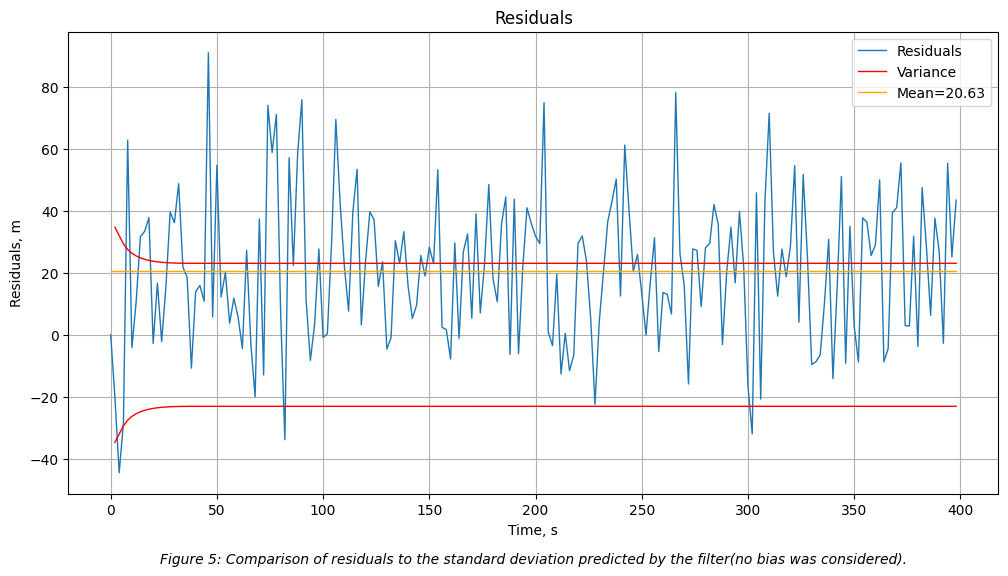

In [174]:
residuals = filter.calc_residuals()
print(f"Mean residual: {np.mean(residuals)}")
limit = np.sqrt(filter.S)

fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, residuals, linewidth=1, alpha=1, label='Residuals')
ax.plot(time[1:], limit[1:], linewidth=1, alpha=1, color='r', label='Variance')
ax.plot(time[1:], -limit[1:], linewidth=1, alpha=1, color='r')
ax.plot([time[0], time[-1]], [residuals.mean(), residuals.mean()], linewidth=1, alpha=1, color='orange', label=f'Mean={residuals.mean():.2f}')
ax.set_xlabel('Time, s')
ax.set_ylabel('Residuals, m')
ax.set_title('Residuals')
ax.grid(True)
ax.legend()
ax.text(0.5, -0.15, "Figure 5: Comparison of residuals to the standard deviation predicted by the filter(no bias was considered).",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()

As you can see from Figure 5, not only residuals frequently exceed upper limit of standard deviation, but the mean is also shifted above 0 by 15.45, which means that model is biased.

# Step 3. Correcting the bias

In this part we take into account the bias to correct our model. It was detected, that process noise has a mean q=0.2. We adjust Kalman Filter prediciton step with this bias and re-run it. The following plot shows the results of this correction.

Mean residual: -1.3060561798748833


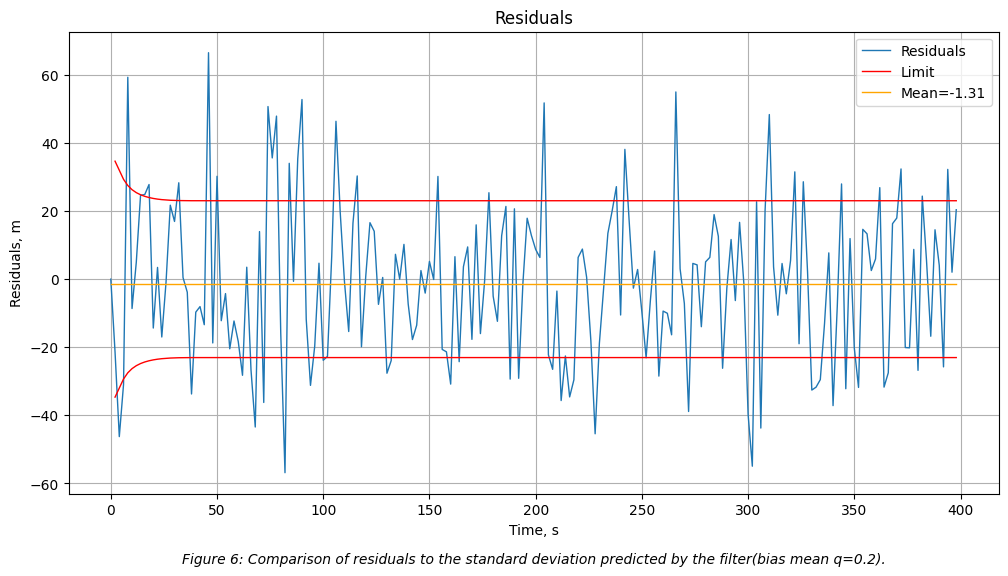

In [175]:
filter.q = 0.2
filtered_measur2 = filter.filter_all()
residuals2 = filter.calc_residuals()
print(f"Mean residual: {residuals2.mean()}")
limit = np.sqrt(filter.S)

fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, residuals2, linewidth=1, alpha=1, label='Residuals')
ax.plot(time[1:], limit[1:], linewidth=1, alpha=1, color='r', label='Limit')
ax.plot(time[1:], -limit[1:], linewidth=1, alpha=1, color='r')
ax.plot([time[0], time[-1]], [residuals2.mean(), residuals2.mean()], linewidth=1, alpha=1, color='orange', label=f'Mean={residuals2.mean():.2f}')

ax.set_xlabel('Time, s')
ax.set_ylabel('Residuals, m')
ax.set_title('Residuals')
ax.grid(True)

ax.legend()
ax.text(0.5, -0.15, "Figure 6: Comparison of residuals to the standard deviation predicted by the filter(bias mean q=0.2).",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()


In this case, as shown in Figure 6, residuals cross the limit far less (most of them are within $\pm \sqrt{S_{i}}$), than previously without considering bias, and the mean (-0.54) is much closer to 0.

# Step 4. Analyzing the true error when ignoring bias of state noise

In this part we compare contributions of systematic estimation error and random estimation error in total error.

In [176]:
filter.filter_all()
filter.mu[0] = [1, 1]
filter.mu_predict[0] = [1, 1]
filter.calc_biased_error()

true_error_x, true_error_v = filter.calc_true_error()


Lets plot true error of position X, standard deviation of X from filter (matrices P) and standard deviation of the measurement noise of X together and analyze plots.

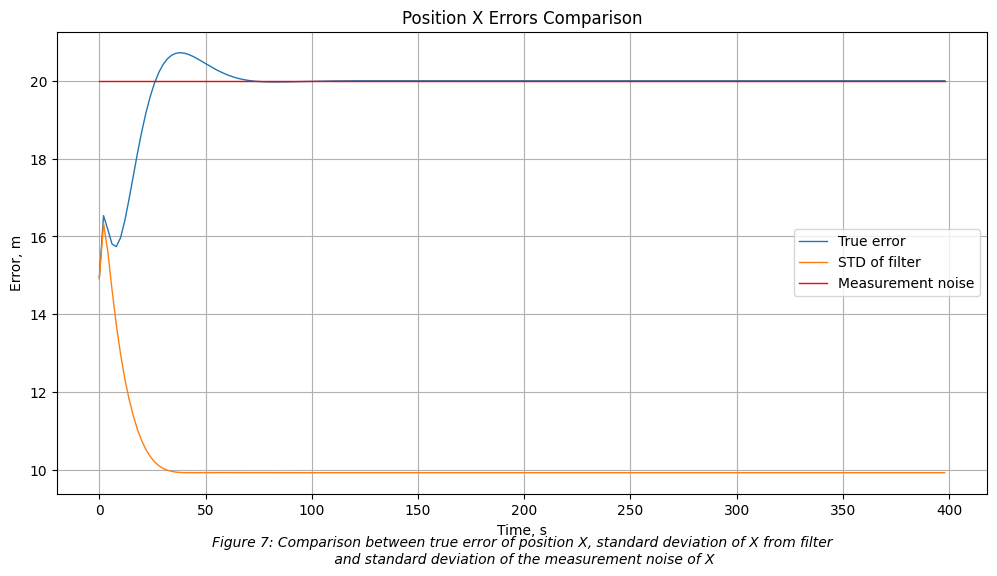

49.61697561830058



In [177]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, true_error_x, linewidth=1, alpha=1, label='True error')
ax.plot(time, np.sqrt(filter.P_filter_arr[:, 0, 0]), linewidth=1, alpha=1, label='STD of filter')
ax.plot(time, np.full_like(time, sigma_measur), linewidth=1, alpha=1, color='r', label='Measurement noise')

ax.set_xlabel('Time, s')
ax.set_ylabel('Error, m')
ax.set_title('Position X Errors Comparison')
ax.grid(True)

ax.legend()
ax.text(0.5, -0.15, "Figure 7: Comparison between true error of position X, standard deviation of X from filter\n and standard deviation of the measurement noise of X",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()
print(np.sqrt(filter.P_filter_arr[:, 0, 0])[-1] / true_error_x[-1] * 100)
print()

Lets analyze Figure 7. Because we assumed zero bias in intial estimate, STD of filter coincide with true error in the begining(up to 10 second). But then, when filter starts to converge, the shift betwenn true error and STD of filter appears, which is around 10m. Thus, we can tell, that STD of filter is only around 50% of total error, which is not enough to eliminate inaccurate error estimates. For that reason we can't call filter optimal, it is overconfident. Also we can notice, that true error converges to level of measurement noise. The reason for that is that in this task specific values of noise and bias were chosen (bias = 0.2, $\sigma_{acc} = 0.2$). If we change them, plot would be different and true error will converge to another value.

Filter errors, derived from matrices P, can be trusted only when there are no signoficat model bias, residuals behave as white noise and appears within $\pm \sqrt{S_{i}}$ area.

The same behaviour we can observe on the next plot(Figure 8).

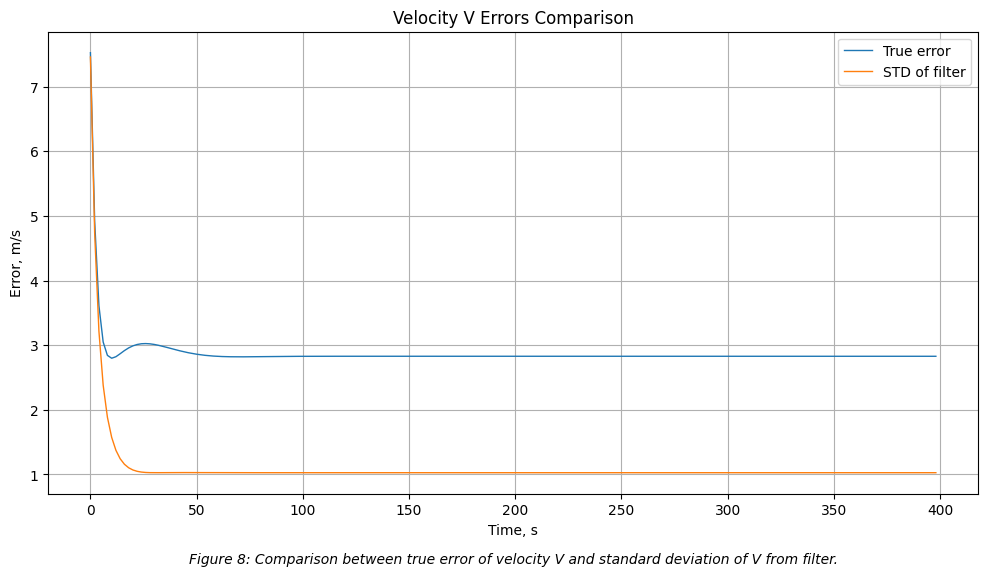

36.30075326869767


In [178]:
fig, ax= plt.subplots( figsize=(12, 6), dpi=100)
ax.plot(time, true_error_v, linewidth=1, alpha=1, label='True error')
ax.plot(time, np.sqrt(filter.P_filter_arr[:, 1, 1]), linewidth=1, alpha=1, label='STD of filter')

ax.set_xlabel('Time, s')
ax.set_ylabel('Error, m/s')
ax.set_title('Velocity V Errors Comparison')
ax.grid(True)

ax.legend()
ax.text(0.5, -0.15, "Figure 8: Comparison between true error of velocity V and standard deviation of V from filter.",
         transform=ax.transAxes, ha='center', fontsize=10, style='italic')

plt.plot()
plt.show()
print(np.sqrt(filter.P_filter_arr[:, 1, 1])[-1]/ true_error_v[-1] * 100)

In case of velocity V, STD of filter is only around 36% of total error, which is less, than for position X, because velocity isn't measured directly and probably because velocity(which is a derivative of position) is more sensitive to systematic errors.

# Conclusion

This project is dedicated to understanding the behaviour of Kalman Filter in cases of accounting for systematic biases and not accounting, comparing contributions of random estimations error and systematic error into total error.

In **Part 1** we applied Kalman filter to measurements, provided by GPS with 2 seconds interval. From Figure 3 we saw that filtered data is systematically shifted from measurements, which indicated a presence of bias in model.

In **Part 2** we ensured, that the bias was in fact present by ploting residual between the measurement at time i and the corresponding prediction for that time step. The mean of residual was shifted by 20.63 above 0, residuals exceeded upper limit of standard deviation too much(Figure 5).

In **Part 3** we took inti account the bias with non zero mean q=0.2 and re-ran Kalman Filter with adjustments in predicition formula. After that the mean of residuals became closer to 0 (-1.31) and stayed within standard deviation, which meant that this correction improved resulting filtered data(Figure 6).

In **Part 4** we compared contributions of random estimations error and systematic error into total error. From Figure 7 STD of filter coincide with true error in the begining(up to 10 second), because initial systematic error was 0. But then, when filter started to converge, the shift betwenn true error and STD of filter appeared, which is around 5.6m. Thus, STD of filter is only around 50% of total error, which is not enough to eliminate inaccurate error estimates. For that reason we can't call filter optimal. Also we can notice, that true error converges to the measurement noise level. The same behaviour occured for velocity(Figure 8), but in this case STD of filter is only around 36% of total error, which is less, than for position X, because velocity isn't measured directly.

To conclude, filter errors, derived from matrices P, can be trusted only when there are no signoficat model bias, residuals behave as white noise and appears within $\pm \sqrt{S_{i}}$ area.